In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

from ultralytics import YOLO

In [2]:
# Download the video
VIDEO_PATH = 'videos/car_traffic.mp4'

#!if [ ! -f $VIDEO_PATH ]; then mkdir -p data && wget https://storage.googleapis.com/track-reid/data/jungling_guy.mp4 -O $VIDEO_PATH; fi

In [3]:
from IPython.display import Video
Video(VIDEO_PATH, width=800,embed=True)

# Converting video to frames

In [4]:
# You can run this only once:
# Transform this VIDEO_PATH into a list of frames in this folder under frames/
!mkdir -p frames && ffmpeg -i $VIDEO_PATH -vf fps=12 frames/%d.png -hide_banner -loglevel panic

In [5]:
available_frames = glob.glob("frames/*.png")
available_frames = sorted(available_frames, key=lambda x: int(x.split("/")[-1].split(".")[0]))


image 1/1 /Users/nicolas.mathieu/Documents/bytetrack/examples/frames/1.png: 384x640 9 persons, 2 bicycles, 8 cars, 2 buss, 1 traffic light, 1 stop sign, 214.8ms
Speed: 1.7ms preprocess, 214.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


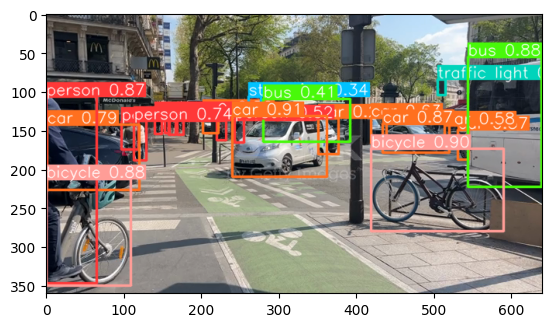

In [6]:
%matplotlib inline

MODEL_WEIGHTS = "yolov8m.pt"

model = YOLO(MODEL_WEIGHTS)
results = model(available_frames[0])[0]

plt.imshow(cv2.cvtColor(results.plot(), cv2.COLOR_BGR2RGB))
plt.show()

#### Classes for prediction 

In [7]:
### We will track only car 
CAR_CLASS_ID = 2
SPORTS_BALL_CLASS_ID = 32

In [8]:
from bytetracker import BYTETracker
from bytetracker.basetrack import BaseTrack
from utils import draw_all_bbox_on_image, yolo_results_to_bytetrack_format, scale_bbox_as_xyxy

#### Yolo model creation and bytetracker creation

In [9]:
tracker = BYTETracker(track_thresh= 0.15, track_buffer = 3, match_thresh = 0.85, frame_rate= 12)
BaseTrack._count = 0
model = YOLO(MODEL_WEIGHTS, task="detect")

#### Detecting object with Yolo model

In [10]:
all_tracked_objects  = []
for frame_id, image_filename in enumerate(available_frames):
    img = cv2.imread(image_filename)
    detections = model.predict(img, classes=[CAR_CLASS_ID], conf=0.15, verbose=False)[0]
    detections_bytetrack_format = yolo_results_to_bytetrack_format(detections)
    tracked_objects = tracker.update(detections_bytetrack_format, frame_id)
    if len(tracked_objects) > 0:
        tracked_objects = np.insert(tracked_objects, 0, frame_id, axis=1)
        all_tracked_objects.append(tracked_objects)

In [11]:
df_tracked = pd.DataFrame(np.concatenate(all_tracked_objects), columns=["frame_id", "x1", "y1", "x2", "y2", "track_id", "class", "confidence"])
df_tracked[["x1", "y1", "x2", "y2"]] = df_tracked[["x1", "y1", "x2", "y2"]].apply(
    lambda x: scale_bbox_as_xyxy(x[0:4], detections.orig_shape), axis=1, result_type="expand"
    )


In [12]:
#fourcc = cv2.VideoWriter_fourcc(*'MPEG')
fourcc = cv2.VideoWriter_fourcc(*'H264')
OUTPUT_WITH_BBOX_NO_REID = "videos/car_traffic_tracked.mp4"
out = cv2.VideoWriter(OUTPUT_WITH_BBOX_NO_REID, fourcc, 12, (1280, 720))
for frame_id, image_filename in enumerate(available_frames):
    image = cv2.imread(image_filename)
    if frame_id in df_tracked.frame_id.astype('int').values:
        df_current_frame = df_tracked[df_tracked.frame_id == frame_id][["x1", "y1", "x2", "y2", "track_id", "class", "confidence"]].to_numpy()
        image = draw_all_bbox_on_image(image, df_current_frame)
    out.write(image)
out.release()
print("Video with bounding box without reid is saved at:", OUTPUT_WITH_BBOX_NO_REID)

OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


Video with bounding box without reid is saved at: videos/car_traffic_tracked.mp4


In [13]:
print("Number of detected objects: ", len(df_tracked.track_id.unique()))

Number of detected objects:  15


In [14]:
from IPython.display import Video

video_path = "videos/car_traffic_tracked.mp4"
display(Video(video_path, embed=True, width=800))